# Generate and parse MEPS data

In [1]:
import sys
import logging
from pathlib import Path

import pandas as pd
import numpy as np

from aif360.datasets import (
    MEPSDataset19,
    MEPSDataset20,
    MEPSDataset21,
    StandardDataset,
)

pip install 'aif360[LawSchoolGPA]'


Important constants!

**NOTE**:
- train and test datasets are pre-determined temporally (train dataset is composed of survey panels 19 and 20, while test dataset is composed of panel 21).
- if `VALIDATION_SIZE is not None`, that portion of the train dataset will be used for validation.

In [2]:
# Which fraction of the train dataset will be used for validation
VALIDATION_SIZE = 0.3
# VALIDATION_SIZE = None

# Whether to use one-hot encoding (or label encoding)
ONE_HOT = False
# ONE_HOT = True

# Whether to use binary sensitive groups or not
BINARY_GROUPS = False
# BINARY_GROUPS = True

# Random seed
SEED = 42

Column names.

In [3]:
label_col = 'UTILIZATION'
protected_attribute_col = 'RACE'
instance_weights_col = 'PERWT15F' # or 'PERWT16F' for panel 21 (year 2016)

categorical_cols = [
    'REGION','SEX','MARRY',
    'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
    'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
    'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
    'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
    'EMPST','POVCAT','INSCOV']

all_cols = [
    'REGION','AGE','SEX','RACE','MARRY',
    'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
    'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
    'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
    'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
    'PCS42', 'MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F'
]

numeric_cols = list(
    set(all_cols)
    - set(categorical_cols)
    - {instance_weights_col, protected_attribute_col, label_col}
)

---

In [4]:
# Add utils to this notebook's sys path
import sys; sys.path.insert(0, str(Path("../scripts/").resolve()))
from utils.meps_preprocessing import custom_meps_preproc, custom_mappings
from functools import partial

In [5]:
if BINARY_GROUPS:
    # This was the original binary-group preprocessing
    data_panel19 = MEPSDataset19()
    data_panel20 = MEPSDataset20()
    data_panel21 = MEPSDataset21()

else:
    # This will use our pre-processing to keep three sensitive groups
    data_panel19 = MEPSDataset19(
        custom_preprocessing=partial(custom_meps_preproc, panel_num=19),
        protected_attribute_names=[protected_attribute_col],
        privileged_classes=[[0.0]],
    )

    data_panel20 = MEPSDataset20(
        custom_preprocessing=partial(custom_meps_preproc, panel_num=20),
        protected_attribute_names=[protected_attribute_col],
        privileged_classes=[[0.0]],
    )

    data_panel21 = MEPSDataset21(
        custom_preprocessing=partial(custom_meps_preproc, panel_num=21),
        protected_attribute_names=[protected_attribute_col],
        privileged_classes=[[0.0]],
    )

Print distribution of samples per sensitive group:

In [6]:
pd.Series(data_panel19.protected_attributes.ravel()).value_counts()

0.0    5656
2.0    5182
1.0    4992
dtype: int64

In [7]:
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler

def parse_meps_data(meps_data: StandardDataset, onehot=True) -> tuple[pd.DataFrame, np.array, np.array]:
    """Parses MEPS data into a pandas DataFrame."""

    df, _metadata = meps_data.convert_to_dataframe(de_dummy_code=not onehot)
    df_enc = df.copy()

    # If `onehot`, use normal scaling on numeric columns (remaining columns will be one-hot encoded)
    if onehot:
        scaler = StandardScaler()
        df_enc_numeric = scaler.fit_transform(df[numeric_cols])

        for idx, num_col in enumerate(numeric_cols):
            df_enc[num_col] = df_enc_numeric[:, idx]
        
        df = df_enc

    # Convert to label encoding if `not onehot`
    else:
        for col_name, col_dtype in df.dtypes.items():
            if not is_numeric_dtype(col_dtype):
                df_enc[col_name], _ = pd.factorize(df[col_name], sort=True)
            
        df = df_enc.astype({
                col_name: "category" if not is_numeric_dtype(col_dtype) else col_dtype
                for col_name, col_dtype in df.dtypes.items()
            })
    
    # Move labels to 1st position (index: 0)
    label_name, = meps_data.label_names    
    label_data = df.pop(label_name)
    df.insert(0, label_name, label_data)
    
    # and sensitive to 2nd position (index: 1)
    sensitive_data = df.pop(protected_attribute_col)
    df.insert(1, protected_attribute_col, sensitive_data)
    
    return df

In [8]:
df19 = parse_meps_data(data_panel19, onehot=ONE_HOT)
df20 = parse_meps_data(data_panel20, onehot=ONE_HOT)
df21 = parse_meps_data(data_panel21, onehot=ONE_HOT)

In [9]:
df19.sample(5)

,UTILIZATION,RACE,AGE,PCS42,MCS42,K6SUM42,REGION,SEX,MARRY,FTSTU,...,ACTLIM,SOCLIM,COGLIM,DFHEAR42,DFSEE42,ADSMOK42,PHQ242,EMPST,POVCAT,INSCOV
9788,1,1,26.0,46.62,31.19,14.0,3,1,4,0,...,2,2,2,2,2,1,5,1,2,0
10365,0,0,55.0,36.74,66.94,0.0,2,0,3,0,...,2,2,2,2,2,2,1,1,3,0
15697,0,0,18.0,-1.00,-1.00,-1.0,2,1,5,1,...,2,2,2,2,2,0,0,4,0,1
11815,0,1,60.0,43.99,57.09,1.0,2,1,0,0,...,2,2,2,2,2,2,1,4,3,0
15240,0,2,27.0,59.18,51.39,5.0,2,1,5,0,...,2,2,2,2,2,2,3,4,4,0


In [10]:
df19[protected_attribute_col].value_counts()

1    5656
0    5182
2    4992
Name: RACE, dtype: int64

**Test data** is drawn from panel 21 (from 2016).

In [11]:
test_df = df21

**Train and validation data** are drawn from panels 19 and 20 (both from 2015).

In [12]:
df19_20 = pd.concat((df19, df20), ignore_index=True)

if VALIDATION_SIZE is None:
    train_df = df19_20
    validation_df = None
    
else:
    n_samples = len(df19_20)
    n_val_samples = int(n_samples * VALIDATION_SIZE)

    perm = np.random.default_rng(SEED).permutation(n_samples)

    validation_idx = perm[: n_val_samples]
    train_idx = perm[n_val_samples: ]
    
    train_df = df19_20.iloc[train_idx]
    validation_df = df19_20.iloc[validation_idx]

In [13]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape : {test_df.shape}")

if VALIDATION_SIZE is not None:
    print(f"Val. shape : {validation_df.shape}")

Train shape: (23380, 42)
Test shape : (15675, 42)
Val. shape : (10020, 42)


---
Let's try to train a classifier to see if data looks OK.

In [14]:
feature_cols = [
    col for col in train_df.columns.to_list()
    if col not in {
        label_col,
        instance_weights_col,
        # protected_attribute_col,  # we're currently using the protected attr col for training
    }
]

In [15]:
%%time
from lightgbm import LGBMClassifier

gbm = LGBMClassifier(n_estimators=200)
gbm.fit(train_df[feature_cols], train_df[label_col])

CPU times: user 1.08 s, sys: 1.62 s, total: 2.7 s
Wall time: 1.31 s


LGBMClassifier(n_estimators=200)

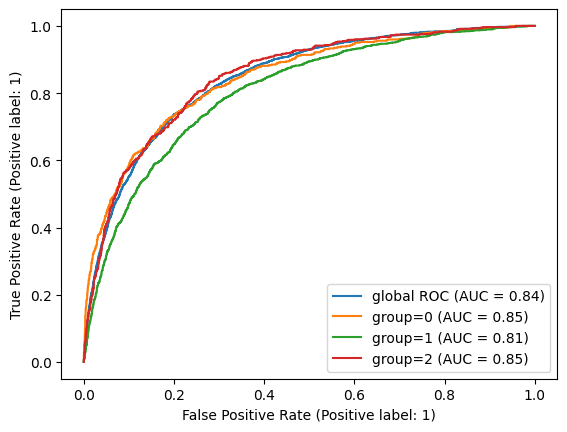

In [16]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_predictions(
    y_true=test_df[label_col],
    y_pred=gbm.predict_proba(test_df[feature_cols])[:, -1],
    name="global ROC")


for g in np.unique(test_df[protected_attribute_col]):
    
    group_filter = test_df[protected_attribute_col] == g

    RocCurveDisplay.from_predictions(
        y_true=test_df[label_col][group_filter],
        y_pred=gbm.predict_proba(test_df[feature_cols])[:, -1][group_filter],
        name=f"group={g}",
        ax=disp.ax_,
    )

---
And finally save to local disk!

In [17]:
# Save data to local disk
root_dir = Path("~").expanduser()
data_dir = root_dir / "data" / "MEPS"
data_dir.mkdir(parents=True, exist_ok=True)

subfolder_name = (
    f"train_{len(train_df)}_"
    f"test_{len(test_df)}_"
    f"val_{len(validation_df) if VALIDATION_SIZE is not None else 0}"
    f"_{df19[protected_attribute_col].nunique()}-groups"
)
subfolder_path = data_dir / subfolder_name
subfolder_path.mkdir(parents=True, exist_ok=True)

print(f"Saving data to folder '{str(subfolder_path)}'.")
train_df.to_csv(subfolder_path / f"MEPS.train{'.1-hot' if ONE_HOT else ''}.csv", header=True, index_label="index")
test_df.to_csv(subfolder_path / f"MEPS.test{'.1-hot' if ONE_HOT else ''}.csv", header=True, index_label="index")

if VALIDATION_SIZE is not None:
    validation_df.to_csv(subfolder_path / f"MEPS.validation{'.1-hot' if ONE_HOT else ''}.csv", header=True, index_label="index")

Saving data to folder '/Users/acruz/data/MEPS/train_23380_test_15675_val_10020_3-groups'.


---